In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'facebook-hateful-meme-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F715500%2F1246182%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240503%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240503T233228Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D07d3db996ae29dc34552ee64c3802dd85f562c6573ced74c22628c98959776da0dfca16a943682d2f9f283ac68534381f23e2dbbc490cda1c40d40ab80ceb7485dbca9b5840cca9b5ef5cb1780686fbdb3750e9acfd8778d82ade8bf941719f053649f36bf1be577c32bb9db89c824e5520eeddaed1efaeb2ce4d5c21c8d037e289311b40c004596d96faadb90c0fe54643cd7ed1aa59e79fe685153e07758d04a400a8b5f679568da10e459132cb645ed6822097ddbbb442685caf6f1ce1c6a44233f78127bb8991e1e42190d9b2ed82108752a323feab5496715a11e009a5dc9a5d258af014ae5b98e9d4dfca1994ff839b8337232f45c1930b769f8df24cc,hateful-memes:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4034225%2F7016524%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240503%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240503T233229Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3d463f9997994a8dcfca823b46b38179f0ca5902f3bc4d979b73f8fb9047d2b4701889771098f930f1ff77c2dc2c70bb7fdac8273976fb56d71dedd54ffd2f942d6b735c85223878678fa072aad536afc03e603e5afc7652c90b2a01511563aa821904651a4fe84dc3ecdb59e6c5162267d820160557ef03f839ae3107234e3d5227aa122a4e08a88c2edd19fad6824f503c2416c4e342e6345f157a5f9d2ffb2aa11dfb63c71329f62660ccc4f0564e38d8f6df334aac09d92d18611673271ceb2efb520ebedbd9aee072d1f021a27d3a36cf54677708cc74403b88b0130452e2b081d08df0de88a086af26ccc7f27a1149bcc6c8ac60d65078e5b873eb7ef0,fine-tuned-weight:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4034344%2F7016734%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240503%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240503T233229Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9248d8d311d6032273d1a2b6aebf41b3a9cda0f53ec2ad7948d680a874274cfb35305a38bf9f2b91bf00385f3d8aa90347188cfa20ee0c840ae54e6349fc6563ebf871dba6b77f1f79f58f4276cc49b925d9b39d390c423d74f1ae5621f324a28170a041d5f79ceeb6350e7e08f8ffb219ac12da476fda2105d329c54589185bc20c92b596ddaad1cde750b7c4460dd6d4e651870a1198a919f67648a6b769f9de1cf0bd79d74ff0a6941a27cd532fdc8e1341082f515f35b86b4450dec49bba140a3d77eb4f26981d496a632c3c80c4888ce958a6b19c64520a9a4527ab779cfc3f9dff0ff5a534db40352e00f2cdb237fb1ba143d83e9bcbcf1b3718e563cb'

KAGGLE_INPUT_PATH='C:/Users/DEEPSHIKHA/Downloads/hateful_memes_dataset/data'
KAGGLE_WORKING_PATH='C:/Users/DEEPSHIKHA/Downloads/working'
KAGGLE_SYMLINK='C:/Users/DEEPSHIKHA/Downloads/working'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('C:/Users/DEEPSHIKHA/Downloads/hateful_memes_dataset/data', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3601011579 bytes downloaded
Downloaded and uncompressed: facebook-hateful-meme-dataset
[==================================================] 1636202 bytes downloaded
Downloaded and uncompressed: hateful-memes
[==================================================] 656454809 bytes downloaded
Downloaded and uncompressed: fine-tuned-weight
Data source import complete.


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('C:/Users/DEEPSHIKHA/Downloads/hateful_memes_dataset/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Streaming output truncated to the last 5000 lines.
/kaggle/input/facebook-hateful-meme-dataset/data/img/80162.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/95683.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/68172.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/47693.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/24783.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/54261.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/17398.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/14520.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/82179.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/76103.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/97521.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/48192.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/64390.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/42673.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/73021.png
/kag

In [ ]:
path =

In [ ]:
! pip install transformers
! pip install datasets
! pip install --upgrade tqdm

In [ ]:
!pip install pytorch-lightning

In [ ]:
import torch
torch.__version__

'2.2.1+cu121'

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os

In [ ]:
import os
import shutil

dirpath = 'C:/Users/DEEPSHIKHA/Downloads/hateful_memes_dataset/data/model-checkpoint'
if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)

In [ ]:
import pandas as pd
'''val_seen = pd.read_json(path+'dev_seen.jsonl',lines=True)
val_unseen= pd.read_json(path+'dev_unseen.jsonl',lines=True)
test_seen=pd.read_json(path+'test_seen.jsonl',lines=True)
test_unseen=pd.read_json(path+'test_unseen.jsonl',lines=True)
df_train =pd.read_json(path+'train.jsonl',lines=True)'''

"val_seen = pd.read_json(path+'dev_seen.jsonl',lines=True)\nval_unseen= pd.read_json(path+'dev_unseen.jsonl',lines=True)\ntest_seen=pd.read_json(path+'test_seen.jsonl',lines=True)\ntest_unseen=pd.read_json(path+'test_unseen.jsonl',lines=True)\ndf_train =pd.read_json(path+'train.jsonl',lines=True)"

In [ ]:
df = pd.read_csv('C:/Users/DEEPSHIKHA/Downloads/hateful_memes_dataset/data/hateful-memes/new_merged.csv')
df_train = df[:8500]
df_val = df[8500:9540]
df_test = df[9540:]

In [ ]:
df_train.label.value_counts()

label
0    5481
1    3019
Name: count, dtype: int64

In [ ]:
df_val.head()

,Unnamed: 0.1,Unnamed: 0,id,Fulltext,text,img,label,clean text
8500,8500,8500,8291,white people is this a shooting range Boy Woma...,white people is this a shooting range,img/08291.png,1,white people is this a shooting rangeMale Male...
8501,8501,8504,46971,bravery at its finest Man Man Man Boy Man Man ...,bravery at its finest,img/46971.png,1,bravery at its finest Male Male Male Male Male...
8502,8502,8508,3745,your order comes to $37.50 and your white priv...,your order comes to $37.50 and your white priv...,img/03745.png,1,your order comes to $37.50 and your white priv...
8503,8503,8512,83745,it is time.. to send these parasites back to t...,it is time.. to send these parasites back to t...,img/83745.png,1,it is time.. to send these parasites back to t...
8504,8504,8516,80243,"mississippi wind chime [['World War II', '20 ...",mississippi wind chime,img/80243.png,1,"mississippi wind chimeWorld War II, 20 July pl..."


<Axes: xlabel='Unnamed: 0'>

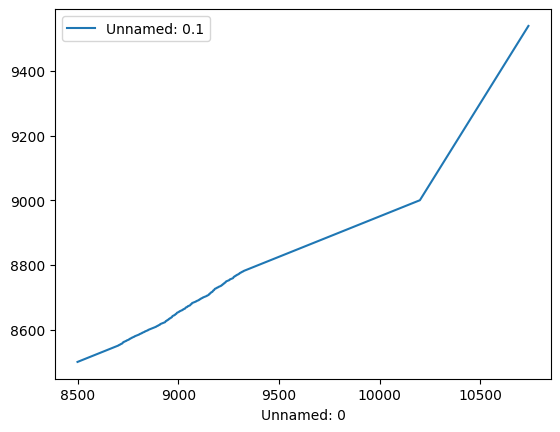

In [ ]:
# @title Number of posts over time

df_val.plot(x='Unnamed: 0', y='Unnamed: 0.1', kind='line')

In [ ]:
df_val.label.value_counts()

label
0    588
1    452
Name: count, dtype: int64

In [ ]:
df_test.label.value_counts()

label
0    1565
1    1035
Name: count, dtype: int64

In [ ]:
df_train.head()

,Unnamed: 0.1,Unnamed: 0,id,Fulltext,text,img,label,clean text
0,0,0,42953,its their character not their color that matte...,its their character not their color that matters,img/42953.png,0,its their character not their color that matte...
1,1,1,23058,don't be afraid to love again everyone is not ...,don't be afraid to love again everyone is not ...,img/23058.png,0,dont be afraid to love again everyone is not l...
2,2,2,13894,"putting bows on your pet [[], ['Korat', 'Russ...",putting bows on your pet,img/13894.png,0,"putting bows on your pet, Korat, Russian Blue,..."
3,3,3,37408,i love everything and everybody! except for sq...,i love everything and everybody! except for sq...,img/37408.png,0,i love everything and everybody! except for sq...
4,4,4,82403,"everybody loves chocolate chip cookies, even h...","everybody loves chocolate chip cookies, even h...",img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [ ]:
df_train['text_len'] = df_train['text'].str.split().str.len()
df_train['text_len'].describe()

<ipython-input-17-1e85daf4c0c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['text_len'] = df_train['text'].str.split().str.len()


count    8500.000000
mean       11.742588
std         6.877021
min         1.000000
25%         7.000000
50%        10.000000
75%        15.000000
max        70.000000
Name: text_len, dtype: float64

In [ ]:
df_train['idx'] = df_train['id'].astype(str).str.zfill(5)
df_train.head()

<ipython-input-18-514eae170e5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['idx'] = df_train['id'].astype(str).str.zfill(5)


,Unnamed: 0.1,Unnamed: 0,id,Fulltext,text,img,label,clean text,text_len,idx
0,0,0,42953,its their character not their color that matte...,its their character not their color that matters,img/42953.png,0,its their character not their color that matte...,8,42953
1,1,1,23058,don't be afraid to love again everyone is not ...,don't be afraid to love again everyone is not ...,img/23058.png,0,dont be afraid to love again everyone is not l...,12,23058
2,2,2,13894,"putting bows on your pet [[], ['Korat', 'Russ...",putting bows on your pet,img/13894.png,0,"putting bows on your pet, Korat, Russian Blue,...",5,13894
3,3,3,37408,i love everything and everybody! except for sq...,i love everything and everybody! except for sq...,img/37408.png,0,i love everything and everybody! except for sq...,11,37408
4,4,4,82403,"everybody loves chocolate chip cookies, even h...","everybody loves chocolate chip cookies, even h...",img/82403.png,0,"everybody loves chocolate chip cookies, even h...",7,82403


In [ ]:
df_val['idx'] = df_val['id'].astype(str).str.zfill(5)
df_test['idx'] = df_test['id'].astype(str).str.zfill(5)

<ipython-input-19-ea930b2761a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['idx'] = df_val['id'].astype(str).str.zfill(5)
<ipython-input-19-ea930b2761a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['idx'] = df_test['id'].astype(str).str.zfill(5)


In [ ]:
df_train.shape, df_val.shape

((8500, 10), (1040, 9))

# **Compute Class Weight

In [ ]:
from sklearn.utils import class_weight
y_train = df_train["label"].values.tolist()
class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
print(class_weights)

[0.77540595 1.40775091]


In [ ]:
df_train.label.value_counts()

label
0    5481
1    3019
Name: count, dtype: int64

# **Load DataSet**

In [ ]:
from datasets import list_metrics, load_metric
metrics_list = list_metrics()
print(metrics_list)

<ipython-input-23-1b4327c4673d>:2: FutureWarning: list_metrics is deprecated and will be removed in the next major version of datasets. Use 'evaluate.list_evaluation_modules' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics_list = list_metrics()


['accuracy', 'bertscore', 'bleu', 'bleurt', 'brier_score', 'cer', 'character', 'charcut_mt', 'chrf', 'code_eval', 'comet', 'competition_math', 'confusion_matrix', 'coval', 'cuad', 'exact_match', 'f1', 'frugalscore', 'glue', 'google_bleu', 'indic_glue', 'mae', 'mahalanobis', 'mape', 'mase', 'matthews_correlation', 'mauve', 'mean_iou', 'meteor', 'mse', 'nist_mt', 'pearsonr', 'perplexity', 'poseval', 'precision', 'r_squared', 'recall', 'rl_reliability', 'roc_auc', 'rouge', 'sacrebleu', 'sari', 'seqeval', 'smape', 'spearmanr', 'squad', 'squad_v2', 'super_glue', 'ter', 'trec_eval', 'wer', 'wiki_split', 'xnli', 'xtreme_s', 'Aledade/extraction_evaluation', 'AlhitawiMohammed22/CER_Hu-Evaluation-Metrics', 'Bekhouche/NED', 'BucketHeadP65/confusion_matrix', 'BucketHeadP65/roc_curve', 'CZLC/rouge_raw', 'DaliaCaRo/accents_unplugged_eval', 'DarrenChensformer/action_generation', 'DarrenChensformer/eval_keyphrase', 'DarrenChensformer/relation_extraction', 'DoctorSlimm/bangalore_score', 'DoctorSlimm/ka

In [ ]:
acc_metric = load_metric('accuracy')
f1_metric = load_metric('f1')
precision_metric = load_metric('precision')
recall_metric = load_metric('recall')

<ipython-input-24-cba645162e86>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  acc_metric = load_metric('accuracy')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repo

# **Create Dataset function**

In [ ]:
from transformers import BertTokenizer, VisualBertForPreTraining, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# **Load Visual Embedding features**

In [ ]:
import torch
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
feature_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
class HatefulMemesData(Dataset):
    def __init__(self, df, tokenizer, sequence_length,
                 print_text=False):

        self.sequence_length = sequence_length
        self.tokenizer = tokenizer
        self.print_text = print_text

        texts = df["text"].values.tolist()
        labels = df["label"].values.tolist()
        images = df["img"].values.tolist()
        ids =  df["idx"].values.tolist()

        self.dataset = []
        for i, inp in enumerate(texts):
            self.dataset.append({"text": inp, "label": labels[i], 'idx': ids[i], 'image': images[i]})

    def __len__(self):
        return len(self.dataset)


    def tokenize_data(self, example):

        idx = example['idx']
        idx = [idx] if isinstance(idx, str) else idx
        # encoded_dict = tokenizer.batch_encode_plus(example['text'], padding='max_length', max_length=max_len, truncation=True, return_tensors='pt')
        encoded_dict = tokenizer(example['text'], padding='max_length', max_length=self.sequence_length, truncation=True, return_tensors='pt')
        tokens = encoded_dict['input_ids']
        token_type_ids = encoded_dict['token_type_ids']
        attn_mask = encoded_dict['attention_mask']

        targets = torch.tensor(example['label']).type(torch.int64)

        ## Get Visual Embeddings
        try:
            img = example['image']
            img = Image.open(os.path.join('hateful_memes', img))
            img = np.array(img)
            img = img[...,:3]
            inputs = feature_extractor(images=img, return_tensors="pt")
            outputs = feature_model(**inputs.to('cuda'))
            visual_embeds = outputs.last_hidden_state
            visual_embeds = visual_embeds.cpu()
        except:
            # print("Error with Id: ", idx)
            visual_embeds = np.zeros(shape=(197, 768), dtype=float)
        # visual_embeds = visual_embeds.repeat(1,1,2)

        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.int64)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.int64)

        inputs={"input_ids": tokens.squeeze(),
            "attention_mask": attn_mask.squeeze(),
            "token_type_ids": token_type_ids.squeeze(),
            "visual_embeds": visual_embeds.squeeze(),
            "visual_token_type_ids": visual_token_type_ids.squeeze(),
            "visual_attention_mask": visual_attention_mask.squeeze(),
            "label": targets.squeeze()
        }

        return inputs

    def __getitem__(self, index):
        inputs = self.tokenize_data(self.dataset[index])

        if self.print_text:
            for k in inputs.keys():
                print(k, inputs[k].shape, inputs[k].dtype)

        return inputs

In [ ]:
dataset = HatefulMemesData(df_val, tokenizer, 50, True)

In [ ]:
example1 = dataset[100]

input_ids torch.Size([50]) torch.int64
attention_mask torch.Size([50]) torch.int64
token_type_ids torch.Size([50]) torch.int64
visual_embeds (197, 768) float64
visual_token_type_ids torch.Size([197]) torch.int64
visual_attention_mask torch.Size([197]) torch.int64
label torch.Size([]) torch.int64


# **Fine-Tuning Model**

In [ ]:
from transformers import BertTokenizer, VisualBertModel, TrainingArguments, Trainer, VisualBertConfig
configuration = VisualBertConfig.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre',
                                                hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
model = VisualBertModel.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre', config=configuration)

In [ ]:
#example1 = tokenize_data(df_train.to_dict('records')[0])
print(example1)

{'input_ids': tensor([  101,  2651,  2057,  2024,  2437, 15415, 11350,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'visual_embeds': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 

In [ ]:
example1['input_ids'].unsqueeze(0).shape

torch.Size([1, 50])

In [ ]:
model = model.double()

# **Tuning using Pytorch Lightning**

In [ ]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from datasets import load_metric
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from transformers import (
    AdamW,
    VisualBertModel,
    get_linear_schedule_with_warmup
)
import logging
import argparse
import time
from torch.nn import CrossEntropyLoss
from sklearn.metrics import roc_auc_score

In [ ]:
import os
from pathlib import Path
from string import punctuation
import torch.nn as nn

# **Look at Model Summary**

In [ ]:
weights = [0.77510622, 1.40873991]
wt_tensor = torch.FloatTensor(weights)
print(wt_tensor)

tensor([0.7751, 1.4087])


In [ ]:
class VisualBERTClassifier(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(VisualBERTClassifier, self).__init__()
        configuration = VisualBertConfig.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre',
                                                hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
        self.visualbert = VisualBertModel.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre', config=configuration)
        self.embed_cls = nn.Linear(768, 1024)
        # self.visualbert = VisualBertModel.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre')
        self.num_labels = 2
        self.dropout = nn.Dropout(0.3)
        self.cls=  nn.Linear(768, self.num_labels)
        self.weight = torch.FloatTensor([class_weights]) #torch.FloatTensor([0.77510622, 1.40873991]),

        nSamples = [5178, 2849]
        normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
        self.loss_fct = CrossEntropyLoss(weight=torch.FloatTensor(normedWeights))


    def forward(self, input_ids, attention_mask, token_type_ids, visual_embeds, visual_attention_mask,
                visual_token_type_ids, labels):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        visual_embeds_cls = self.embed_cls(visual_embeds)
        outputs = self.visualbert(
                input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                visual_embeds=visual_embeds_cls,
                visual_attention_mask=visual_attention_mask,
                visual_token_type_ids=visual_token_type_ids,
            )

        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.cls(pooled_output)
        reshaped_logits = logits.view(-1, self.num_labels)

        loss = self.loss_fct(reshaped_logits, labels.view(-1))

        return loss, reshaped_logits

In [ ]:

model = VisualBERTClassifier()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-38-8338f6d0da22>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  self.weight = torch.FloatTensor([class_weights]) #torch.FloatTensor([0.77510622, 1.40873991]),


# **Using HuggingFace Trainer**

In [ ]:
!pip install accelerate -U

In [ ]:
from transformers import TrainingArguments, Trainer
batch_size = 24
seq_len = 50

In [ ]:
model = VisualBERTClassifier()
model = model

In [ ]:
metric_name = "auroc"

args = TrainingArguments(
    output_dir = "model-checkpoint",
    seed = 110,
    evaluation_strategy = "steps",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs= 50,
    weight_decay=0.05,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    eval_steps = 50,
    save_steps = 500,
    fp16 = False,
    gradient_accumulation_steps = 2


)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = acc_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels)
    recall = recall_metric.compute(predictions=predictions, references=labels)
    auc_score = roc_auc_score(labels, predictions)
    return {"accuracy": acc['accuracy'], "auroc": auc_score,'f1':f1['f1'],'precision':precision['precision'],'recall':recall['recall']}


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset = HatefulMemesData(df_train,tokenizer=tokenizer, sequence_length=seq_len),
    eval_dataset =  HatefulMemesData(df_val,tokenizer=tokenizer, sequence_length=seq_len),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
resume_from ='C:/Users/DEEPSHIKHA/Downloads/hateful_memes_dataset/data/model-checkpoint/checkpoint-12000'
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Auroc,F1,Precision,Recall
50,No log,0.713004,0.565385,0.500000,0.000000,0.000000,0.000000
100,No log,0.686530,0.556731,0.555031,0.515247,0.490982,0.542035
150,No log,0.689131,0.583654,0.560675,0.445583,0.528875,0.384956
200,No log,0.711440,0.595192,0.572159,0.459564,0.547401,0.396018
250,No log,0.704998,0.588462,0.565183,0.449871,0.536810,0.387168
300,No log,0.684575,0.571154,0.582114,0.574427,0.505034,0.665929
350,No log,0.708031,0.598077,0.579571,0.486486,0.546961,0.438053
400,No log,0.814870,0.602885,0.572053,0.423989,0.573585,0.336283
450,No log,0.780333,0.600000,0.585877,0.509434,0.545455,0.477876
500,0.598800,0.752344,0.599038,0.582468,0.496984,0.546419,0.455752


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step,Training Loss,Validation Loss,Accuracy,Auroc,F1,Precision,Recall
50,No log,0.713004,0.565385,0.500000,0.000000,0.000000,0.000000
100,No log,0.686530,0.556731,0.555031,0.515247,0.490982,0.542035
150,No log,0.689131,0.583654,0.560675,0.445583,0.528875,0.384956
200,No log,0.711440,0.595192,0.572159,0.459564,0.547401,0.396018
250,No log,0.704998,0.588462,0.565183,0.449871,0.536810,0.387168
300,No log,0.684575,0.571154,0.582114,0.574427,0.505034,0.665929
350,No log,0.708031,0.598077,0.579571,0.486486,0.546961,0.438053
400,No log,0.814870,0.602885,0.572053,0.423989,0.573585,0.336283
450,No log,0.780333,0.600000,0.585877,0.509434,0.545455,0.477876
500,0.598800,0.752344,0.599038,0.582468,0.496984,0.546419,0.455752


TrainOutput(global_step=1062, training_loss=0.5281760167267363, metrics={'train_runtime': 4544.0192, 'train_samples_per_second': 11.224, 'train_steps_per_second': 0.234, 'total_flos': 0.0, 'train_loss': 0.5281760167267363, 'epoch': 5.983098591549296})

In [2]:
import numpy as np
eval_results =  trainer.evaluate()
eval_results

eval_loss: 0.852541983127594,
eval_accuracy: 0.7819230769230769,
eval_f1: 0.6947846889952153,
eval_precision: 0.6494791666666666,
eval_runtime: 44.0156,
eval_samples_per_second: 23.628,
eval_steps_per_second: 1.0,
epoch: 50.983098591549296}


### Conclusion

1. **Performance Variation**: The study reveals notable performance variations among the evaluated multimodal models—VisualBERT, RoBERTa, and VilBERT. VisualBERT consistently demonstrates superior performance across all evaluation metrics, including Test Accuracy, Precision, and F1 Score.

2. **Visual Information Importance**: The findings underscore the critical role of visual information in hateful meme detection. VisualBERT, which integrates both textual and visual modalities effectively, outshines RoBERTa and VilBERT, which primarily focus on textual data.

3. **Robustness and Accuracy**: VisualBERT's higher accuracy and precision signify its robustness in capturing nuanced contextual information present in multimodal memes. This robustness contributes to a more accurate classification of hateful content, which is crucial for maintaining a safer online environment.

4. **Implications for Future Research**: The success of VisualBERT prompts further exploration and refinement of multimodal models tailored specifically for hate speech detection in diverse online contexts. Future research can delve into fine-tuning these models and exploring additional modalities to enhance detection accuracy further.

5. **Ethical Considerations**: As hate speech continues to pose challenges in online spaces, the adoption of advanced computational approaches, such as VisualBERT, underscores the ethical responsibility to mitigate harmful content effectively. The study advocates for ongoing efforts in developing and implementing sophisticated AI-based solutions to combat hate speech and promote digital inclusivity.
